In [1]:
import numpy as np

import pandas as pd

import torch
from torch.utils.data import DataLoader

from torchfm.dataset.movielens import MovieLens20MDataset
from torchfm.layer import FeaturesEmbedding, MultiLayerPerceptron

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from adjustText import adjust_text

## Redefine some torchfm classes

Modify `MovieLensDataset` to take 0-indexed movie and user IDs and leave the targets as the raw scores

In [2]:
class MovieLensDataset(torch.utils.data.Dataset):
    """
    MovieLens Dataset
    Data preparation
        treat samples with a rating less than 3 as negative samples
    :param dataset_path: MovieLens dataset path
    Reference:
        https://grouplens.org/datasets/movielens
    """

    def __init__(self, dataset_path, sep=',', engine='c', header='infer'):
        data = pd.read_csv(dataset_path, sep=sep, engine=engine, header=header).to_numpy()[:, :3]
        self.items = data[:, :2].astype(np.int)
        self.targets = data[:, 2].astype(np.float32)
        self.field_dims = np.max(self.items, axis=0) + 1
        self.user_field_idx = np.array((0, ), dtype=np.long)
        self.item_field_idx = np.array((1,), dtype=np.long)

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

    def __preprocess_target(self, target):
        target[target <= 3] = 0
        target[target > 3] = 1
        return target

Modify `NeuralCollaborativeFiltering` to remove sigmoid on the output to train with MSE

In [3]:
class NeuralCollaborativeFiltering(torch.nn.Module):
    """
    A pytorch implementation of Neural Collaborative Filtering.
    Reference:
        X He, et al. Neural Collaborative Filtering, 2017.
    """

    def __init__(self, field_dims, user_field_idx, item_field_idx, embed_dim, mlp_dims, dropout):
        super().__init__()
        self.user_field_idx = user_field_idx
        self.item_field_idx = item_field_idx
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.embed_output_dim = len(field_dims) * embed_dim
        self.mlp = MultiLayerPerceptron(self.embed_output_dim, mlp_dims, dropout, output_layer=False)
        self.fc = torch.nn.Linear(mlp_dims[-1] + embed_dim, 1)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_user_fields)``
        """
        x = self.embedding(x)
        user_x = x[:, self.user_field_idx].squeeze(1)
        item_x = x[:, self.item_field_idx].squeeze(1)
        x = self.mlp(x.view(-1, self.embed_output_dim))
        gmf = user_x * item_x
        x = torch.cat([gmf, x], dim=1)
        x = self.fc(x).squeeze(1)
        return x

## Load dataset

In [4]:
dataset = MovieLensDataset("data.csv")

C:\Users\cruzs\AppData\Local\Temp/ipykernel_14916/2639281332.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.items = data[:, :2].astype(np.int)
C:\Users\cruzs\AppData\Local\Temp/ipykernel_14916/2639281332.py:16: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When

In [39]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [109_351, 12_150])

train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False)

## Create Model
Hyperparameters tuned by hand-experimentation

In [40]:
k = 32

model = NeuralCollaborativeFiltering(
    dataset.field_dims,
    dataset.user_field_idx, 
    dataset.item_field_idx, 
    embed_dim=k, 
    mlp_dims=(k, k),
    dropout=0.0).cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=6e-3)

model

NeuralCollaborativeFiltering(
  (embedding): FeaturesEmbedding(
    (embedding): Embedding(2492, 32)
  )
  (mlp): MultiLayerPerceptron(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.0, inplace=False)
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.0, inplace=False)
    )
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

## Train and test model

In [7]:
def test(model, data_loader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for fields, target in data_loader:
            fields, target = fields.to(device), target.to(device)
            y = model(fields)
            loss = criterion(y, target)
            total_loss += loss.item()

    return total_loss / len(data_loader)

In [41]:
log_interval = 20
n_epochs = 40

losses = []

model.train()

tk0 = tqdm(range(n_epochs), total=n_epochs)
for epoch in tk0:
    total_loss = 0
    for i, (fields, target) in enumerate(train_loader):
        fields, target = fields.cuda(), target.cuda()

        y = model(fields)
        loss = criterion(y, target.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if (i + 1) % log_interval == 0:
            losses.append(total_loss / log_interval)
            tk0.set_postfix(loss=total_loss / log_interval)
            total_loss = 0

    test_loss = test(model, val_loader, "cuda:0")
    print(f"epoch {epoch+1} validation loss: {test_loss}")

  0%|          | 0/40 [00:00<?, ?it/s]

epoch 1 validation loss: 5.513988733291626
epoch 2 validation loss: 0.7391547163327535
epoch 3 validation loss: 0.7156277000904083
epoch 4 validation loss: 0.7099429269631704
epoch 5 validation loss: 0.7075241406758627
epoch 6 validation loss: 0.7073000967502594
epoch 7 validation loss: 0.7004997928937277
epoch 8 validation loss: 0.6960318883260092
epoch 9 validation loss: 0.6973325709501902
epoch 10 validation loss: 0.6921008626619974
epoch 11 validation loss: 0.6921882629394531
epoch 12 validation loss: 0.6890802582105001
epoch 13 validation loss: 0.6932341555754343
epoch 14 validation loss: 0.6854473054409027
epoch 15 validation loss: 0.6858499646186829
epoch 16 validation loss: 0.6868415176868439
epoch 17 validation loss: 0.686481108268102
epoch 18 validation loss: 0.688332736492157
epoch 19 validation loss: 0.6825851301352183
epoch 20 validation loss: 0.6836032569408417
epoch 21 validation loss: 0.6784791350364685
epoch 22 validation loss: 0.6804772913455963
epoch 23 validation lo

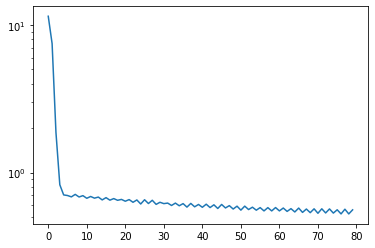

In [42]:
plt.plot(losses)
plt.yscale("log")

In [29]:
dataset.items[4], dataset.targets[0]

(array([   0, 1230]), 4.0)

In [43]:
model(torch.tensor(dataset.items[0]).cuda())

tensor([3.7503], device='cuda:0', grad_fn=<SqueezeBackward1>)

## Extract user and movie embeddings

In [45]:
user_embedding = np.zeros((dataset.field_dims[0], k))
movie_embedding = np.zeros((dataset.field_dims[1], k))

for i in range(len(user_embedding)):
    user_embedding[i] = model.embedding.forward(torch.tensor([i, 0]).cuda()).detach().cpu().numpy()[0,0]

for i in range(len(movie_embedding)):
    movie_embedding[i] = model.embedding.forward(torch.tensor([0, i]).cuda()).detach().cpu().numpy()[0,1]

user_embedding.shape, movie_embedding.shape

((992, 32), (1500, 32))

## Load movie data for visualization

In [16]:
# Read movies.csv and make dict of movie titles to movie ids
movies = pd.read_csv("movies.csv")
movie_titles = movies["Movie Title"].tolist()
movie_ids = movies["Movie ID"].tolist()
movie_dict = dict(zip(movie_titles, movie_ids))

# Make a list of movie IDs for each genre
action_ids = movies[movies["Action"] == 1]["Movie ID"].tolist()
adventure_ids = movies[movies["Adventure"] == 1]["Movie ID"].tolist()
animation_ids = movies[movies["Animation"] == 1]["Movie ID"].tolist()
children_ids = movies[movies["Children"] == 1]["Movie ID"].tolist()
comedy_ids = movies[movies["Comedy"] == 1]["Movie ID"].tolist()
crime_ids = movies[movies["Crime"] == 1]["Movie ID"].tolist()
documentary_ids = movies[movies["Documentary"] == 1]["Movie ID"].tolist()
drama_ids = movies[movies["Drama"] == 1]["Movie ID"].tolist()
fantasy_ids = movies[movies["Fantasy"] == 1]["Movie ID"].tolist()
film_noir_ids = movies[movies["Film-Noir"] == 1]["Movie ID"].tolist()
horror_ids = movies[movies["Horror"] == 1]["Movie ID"].tolist()
musical_ids = movies[movies["Musical"] == 1]["Movie ID"].tolist()
mystery_ids = movies[movies["Mystery"] == 1]["Movie ID"].tolist()
romance_ids = movies[movies["Romance"] == 1]["Movie ID"].tolist()
sci_fi_ids = movies[movies["Sci-Fi"] == 1]["Movie ID"].tolist()
thriller_ids = movies[movies["Thriller"] == 1]["Movie ID"].tolist()
war_ids = movies[movies["War"] == 1]["Movie ID"].tolist()
western_ids = movies[movies["Western"] == 1]["Movie ID"].tolist()

In [17]:
# Count number of ratings for each movie by counting occurences of movie ids in dataset
movie_ratings = dataset.items[:,1]
movie_rating_counts = np.bincount(movie_ratings)

movie_avg_ratings = np.zeros(len(movie_rating_counts))
for i in range(len(movie_rating_counts)):
    movie_avg_ratings[i] = np.mean(dataset.targets[dataset.items[:,1] == i])

# Sort movies by number of ratings
popular_movie_ids = np.argsort(movie_rating_counts)[::-1]

# Sort movies by average rating
top_movie_ids = np.argsort(movie_avg_ratings)[::-1]

print("Top 10 movies by number of ratings:")
for i in range(10):
    movie_id = popular_movie_ids[i]
    print(f"{movie_titles[movie_id]}: {movie_rating_counts[movie_id]} ratings")

print()

print("Top 10 movies by average rating:")
for i in range(10):
    movie_id = top_movie_ids[i]
    print(f"{movie_titles[movie_id]}: {movie_avg_ratings[movie_id]} average rating")

Top 10 movies by number of ratings:
Lord of the Rings: The Fellowship of the Ring, The (2001): 747 ratings
Lord of the Rings: The Two Towers, The (2002): 713 ratings
Lord of the Rings: The Return of the King, The (2003): 698 ratings
Shrek (2001): 610 ratings
Pirates of the Caribbean: The Curse of the Black Pearl (2003): 585 ratings
Dark Knight, The (2008): 561 ratings
Finding Nemo (2003): 528 ratings
Kill Bill: Vol. 1 (2003): 520 ratings
Monsters, Inc. (2001): 519 ratings
Ocean's Eleven (2001): 517 ratings

Top 10 movies by average rating:
Planet Earth (2006): 4.467741966247559 average rating
Black Mirror: White Christmas (2014): 4.454545497894287 average rating
Akeelah and the Bee (2006): 4.300000190734863 average rating
Barbarian Invasions, The (Les invasions barbares) (2003): 4.275000095367432 average rating
Louis C.K.: Live at The Comedy Store (2015): 4.264705657958984 average rating
Blue Is the Warmest Color (La vie d'Adèle) (2013): 4.258620738983154 average rating
Elite Squad: Th

## Visualization/Testing

In [46]:
# find top 10 similar movies to something
movie_id = movie_dict["Finding Nemo (2003)"]
vec = movie_embedding[movie_id]

# Find cosine similarity between movie and all other movies
cosine_sim = np.dot(movie_embedding, vec) / (np.linalg.norm(movie_embedding, axis=1) * np.linalg.norm(vec))
top_10 = np.argsort(cosine_sim)[:-20:-1]

for id in top_10:
    print(movie_titles[id])

Finding Nemo (2003)
Monsters, Inc. (2001)
Incredibles, The (2004)
How to Train Your Dragon (2010)
Up (2009)
Batman: The Dark Knight Returns, Part 2 (2013)
Kung Fu Panda (2008)
Ratatouille (2007)
Dawn of the Planet of the Apes (2014)
Shrek (2001)
Megamind (2010)
Home (2015)
Transamerica (2005)
Hotel Rwanda (2004)
Wreck-It Ralph (2012)
Paperman (2012)
Descendants, The (2011)
Toy Story 3 (2010)
Up in the Air (2009)


(32, 1500) (32, 32)
(2, 1500)


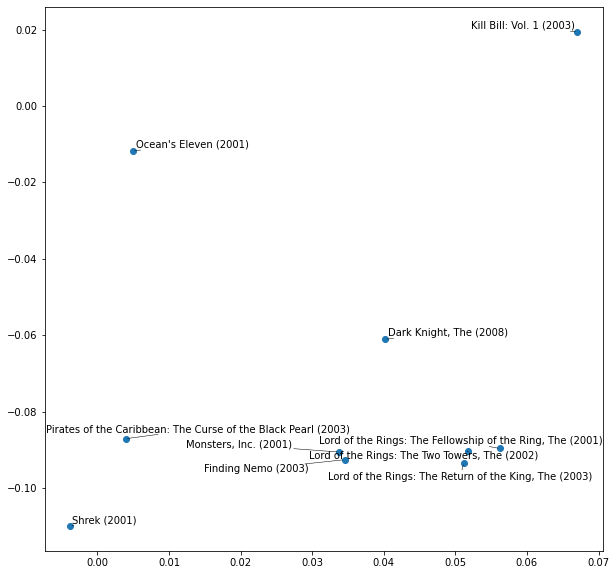

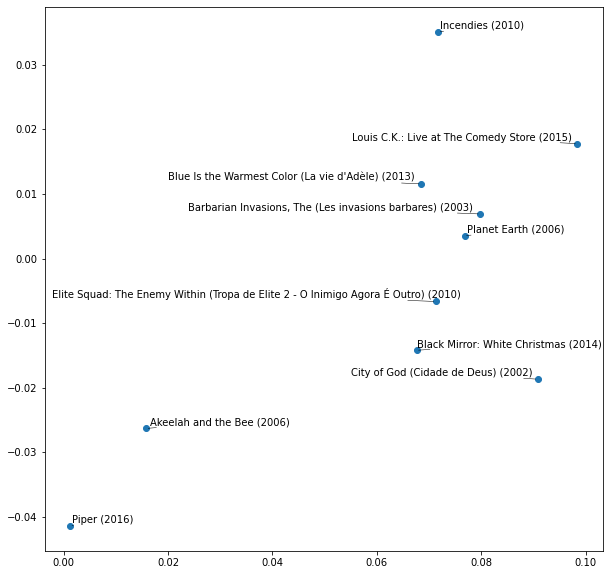

In [58]:
# Compute SVD of movie_embedding
V = movie_embedding.T # put movies on columns
V -= np.mean(V, axis=0) # subtract mean

A, s, B = np.linalg.svd(V, full_matrices=False)

print(V.shape, A.shape)
movie_projected = A[:, :2].T @ V
print(movie_projected.shape)

# Plot the first 2 principal components of the movie embedding for the 10 most popular movies
n_movies = 10

%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}

def plot_svd(movie_list, filename=None, title=None):
    plt.figure(figsize=(10, 10))
    # plt.scatter(movie_projected[0, movie_ids], movie_projected[1, movie_ids], alpha=0.1, color="k")
    var = plt.scatter(movie_projected[0, movie_list], movie_projected[1, movie_list])
    texts = [plt.text(movie_projected[0, id], movie_projected[1, id], movie_titles[id]) for id in movie_list]
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

    plt.title(title)

    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="w")

    plt.show()

plot_svd(popular_movie_ids[:n_movies], "popular_movies.png")
plot_svd(top_movie_ids[:n_movies], "top_movies.png")

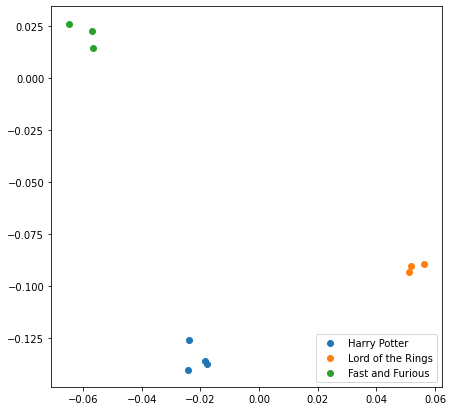

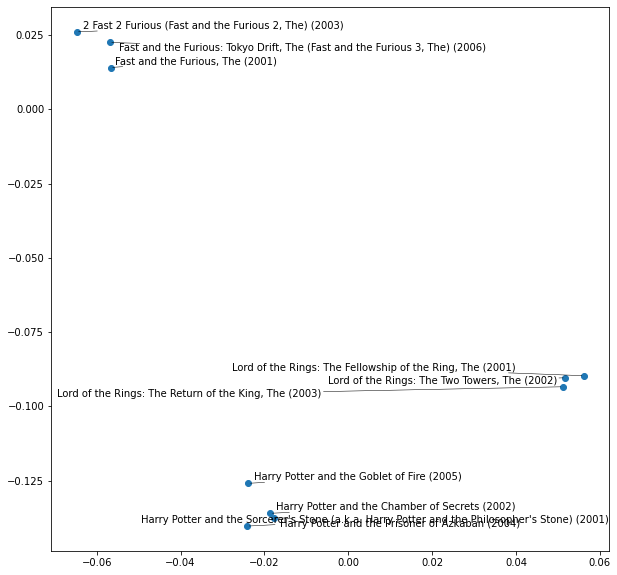

In [56]:
harry_potter = [
    "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)",
    "Harry Potter and the Chamber of Secrets (2002)",
    "Harry Potter and the Prisoner of Azkaban (2004)",
    "Harry Potter and the Goblet of Fire (2005)",
    # "Harry Potter and the Order of the Phoenix (2007)",
    # "Harry Potter and the Half-Blood Prince (2009)",
    # "Harry Potter and the Deathly Hallows: Part 1 (2010)",
    # "Harry Potter and the Deathly Hallows: Part 2 (2011)",
]
harry_potter_ids = [movie_dict[movie] for movie in harry_potter]

lotr = [
    "Lord of the Rings: The Fellowship of the Ring, The (2001)",
    "Lord of the Rings: The Two Towers, The (2002)",
    "Lord of the Rings: The Return of the King, The (2003)",
]
lotr_ids = [movie_dict[movie] for movie in lotr]

fast = [
    "Fast and the Furious, The (2001)",
    "2 Fast 2 Furious (Fast and the Furious 2, The) (2003)",
    "Fast and the Furious: Tokyo Drift, The (Fast and the Furious 3, The) (2006)",
    # "Fast & Furious (Fast and the Furious 4, The) (2009)",
    # "Fast Five (Fast and the Furious 5, The) (2011)",
    # "Fast & Furious 6 (Fast and the Furious 6, The) (2013)",
]
fast_ids = [movie_dict[movie] for movie in fast]

bourne = [
    "Bourne Identity, The (2002)",
    "Bourne Supremacy, The (2004)",
    "Bourne Ultimatum, The (2007)",
    "Bourne Legacy, The (2012)",
]
bourne_ids = [movie_dict[movie] for movie in bourne]

ice_age = [
    "Ice Age (2002)",
    "Ice Age 2: The Meltdown (2006)",
    "Ice Age: Dawn of the Dinosaurs (2009)",
    "Ice Age 4: Continental Drift (2012)",
]
ice_age_ids = [movie_dict[movie] for movie in ice_age]

plt.figure(figsize=(7, 7))
# plt.scatter(movie_projected[0, movie_ids], movie_projected[1, movie_ids], alpha=0.1, color="k")
plt.scatter(movie_projected[0, harry_potter_ids], movie_projected[1, harry_potter_ids], label="Harry Potter")
plt.scatter(movie_projected[0, lotr_ids], movie_projected[1, lotr_ids], label="Lord of the Rings")
plt.scatter(movie_projected[0, fast_ids], movie_projected[1, fast_ids], label="Fast and Furious")
# plt.scatter(movie_projected[0, bourne_ids], movie_projected[1, bourne_ids], label="Jason Bourne")
# plt.scatter(movie_projected[0, ice_age_ids], movie_projected[1, ice_age_ids], label="Ice Age")
plt.legend(loc="lower right")
# plt.ylim(-0.1, 0.15)

plt.savefig("movie_clusters.png", dpi=300, bbox_inches="tight", facecolor="w")

plot_svd(harry_potter_ids + lotr_ids + fast_ids, "movie_clusters.png")

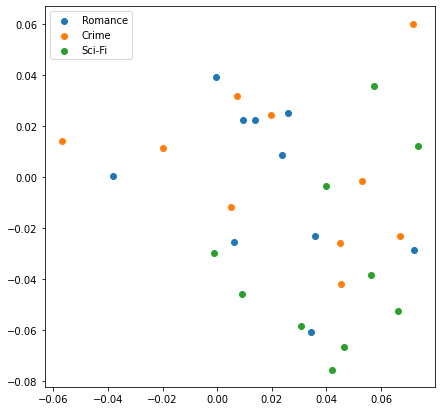

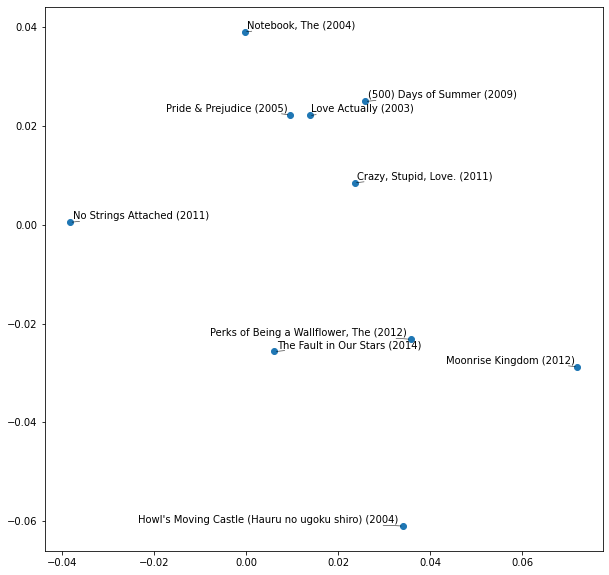

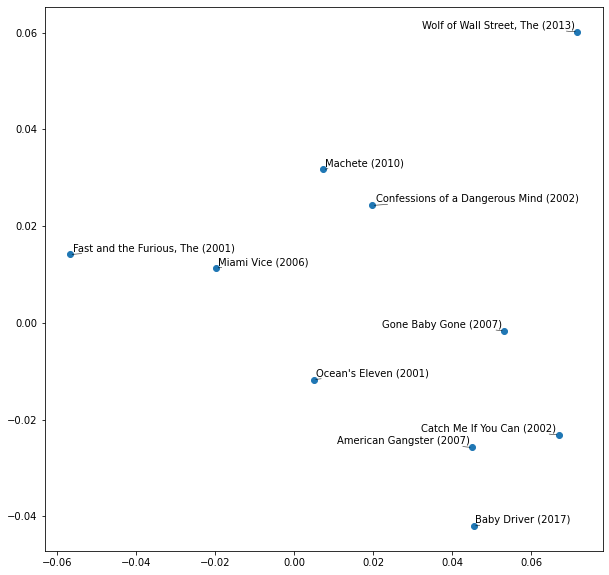

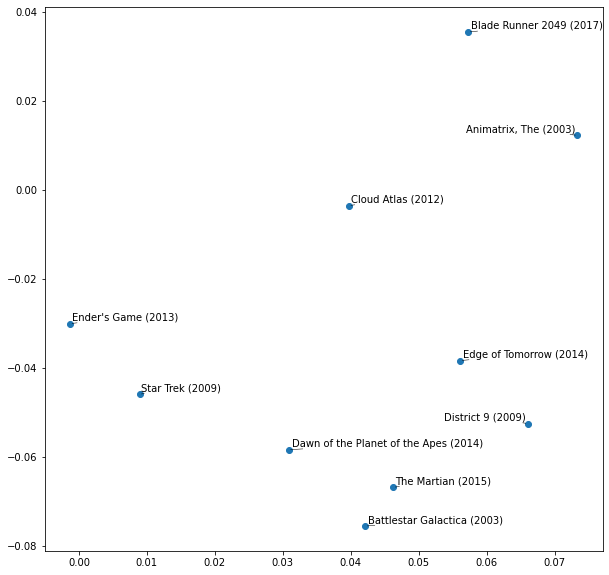

In [57]:
# Plot romance, crime, and sci-fi movies
romance = [
    "(500) Days of Summer (2009)",
    "Crazy, Stupid, Love. (2011)",
    "Moonrise Kingdom (2012)",
    "Notebook, The (2004)",
    "The Fault in Our Stars (2014)",
    "Howl's Moving Castle (Hauru no ugoku shiro) (2004)",
    "Love Actually (2003)",
    "No Strings Attached (2011)",
    "Pride & Prejudice (2005)",
    "Perks of Being a Wallflower, The (2012)",
]
romance_ids = [movie_dict[movie] for movie in romance]

crime = [
    "American Gangster (2007)",
    "Baby Driver (2017)",
    "Catch Me If You Can (2002)",
    "Confessions of a Dangerous Mind (2002)",
    "Gone Baby Gone (2007)",
    "Fast and the Furious, The (2001)",
    "Miami Vice (2006)",
    "Ocean's Eleven (2001)",
    "Machete (2010)",
    "Wolf of Wall Street, The (2013)",
]
crime_ids = [movie_dict[movie] for movie in crime]

sci_fi = [
    "Animatrix, The (2003)",
    "Battlestar Galactica (2003)",
    "Blade Runner 2049 (2017)",
    "Cloud Atlas (2012)",
    "Dawn of the Planet of the Apes (2014)",
    "District 9 (2009)",
    "Edge of Tomorrow (2014)",
    "Ender's Game (2013)",
    "Star Trek (2009)",
    "The Martian (2015)",
]
sci_fi_ids = [movie_dict[movie] for movie in sci_fi]

plt.figure(figsize=(7, 7))
plt.scatter(movie_projected[0, romance_ids], movie_projected[1, romance_ids], label="Romance")
plt.scatter(movie_projected[0, crime_ids], movie_projected[1, crime_ids], label="Crime")
plt.scatter(movie_projected[0, sci_fi_ids], movie_projected[1, sci_fi_ids], label="Sci-Fi")
plt.legend()

plt.savefig("genres.png", dpi=300, bbox_inches="tight", facecolor="w")

plot_svd(romance_ids, "romance.png")
plot_svd(crime_ids, "crime.png")
plot_svd(sci_fi_ids, "sci_fi.png")

c:\Users\cruzs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


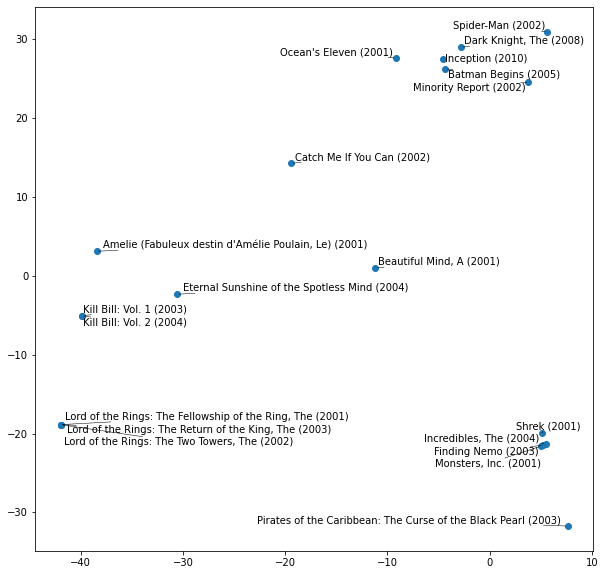

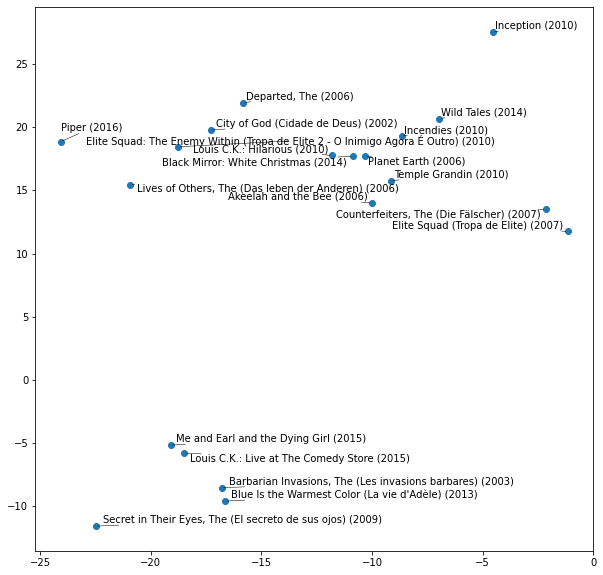

In [51]:
from sklearn.manifold import TSNE

# Compute t-SNE embedding of movie embedding
tsne = TSNE(n_components=2, learning_rate="auto", init="pca")
tsne_embedding = tsne.fit_transform(movie_embedding)

# Plot the first 2 principal components of the movie embedding for the 10 most popular movies
def plot_tsne(movie_list, filename=None):
    plt.figure(figsize=(10, 10))
    var = plt.scatter(tsne_embedding[movie_list, 0], tsne_embedding[movie_list, 1])
    texts = [plt.text(tsne_embedding[id, 0], tsne_embedding[id, 1], movie_titles[id]) for id in movie_list]
    adjust_text(texts, only_move={'text':'y'}, lim=30, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="w")

    plt.show()

plot_tsne(popular_movie_ids[:20], "tsne_popular.png")
plot_tsne(top_movie_ids[:20], "tsne_top.png")

In [67]:
# Save model and embeddings
torch.save(model.state_dict(), "model.pt")
np.save("user_embedding.npy", user_embedding)
np.save("movie_embedding.npy", movie_embedding)